# Signal LOC reçu par l'avion

Franck Daout

septembre 2023

In [1]:
%pylab 
%matplotlib inline

Using matplotlib backend: <object object at 0x7faf759872d0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


:::{admonition} Objectifs de cette page
:class: note
    
Dans cette partie, nous allons simuler le signal "localizer" reçu par l'avion (dans la suite nous l'appellerons signal LOC). Pour cela nous allons:
1. "Fabriquer" le signal en bande de base reçu par l'avion
2. Moduler ce signal (modulation d'amplitude et transposition autour de la fréquence RF)
3. Simuler l'effet du canal de propagation

:::

## Signal en bande de base

Le signal reçu par l'avion correspond à une somme pondérée des signaux RF modulés à 90Hz ($V_{RF90}$) et 150Hz ($V_{RF150}$) :


$$
V_{RF} = (1 - \alpha)V_{RF150} + \alpha V_{RF90}
$$

La valeur de $\alpha$ permet de sélectionner le décalage de l'avion par rapport à la piste. Si $\alpha=0.5$ l'avion est aligné sur l'axe de la piste, si $\alpha<0.5$ l'avion est à gauche de la piste, le pilote devra corriger en orientant l'avion vers la droite pour le recentrer. Dans le cas où l'avion est à droite de la piste, la valeur de $\alpha>0.5$ 

Le signal $V_{RF}$ s'exprime en fonction des signaux modulant $V_{90}$ et $V_{150}$ :

$$
V_{RF} = (1 - \alpha) A_{RF}(1 + m V_{150})\cos(2 \pi f_c t) + \alpha A_{RF}(1 + m V_{90})\cos(2 \pi f_c t)
$$

avec $A_{RF}$ l'amplitude de la porteuse, $m$ le taux de modulation et $f_c$ la fréquence de la porteuse.

L'expression de $V_{RF}$ peut se mettre sous la forme :

$$
V_{RF} = A_{RF}(1 + m V_{base})\cos(2 \pi f_c t)
$$

avec 

$$
V_{base} = \alpha V_{90} + (1 - \alpha) V_{150}
$$

$V_{base}$ est le signal en bande de base (i.e. le modulant) que nous allons fabriquer. Pour cela deux générateurs d'onde CW sont créés. Le premier générateur à une fréquence de 90Hz ($f_1=90$ Hz) et une amplitude de 1V ($V_{90}(t)= 1 \cos(2\pi f_1t)$). Le second génère une onde de fréquence 150Hz ($f_2=150$ Hz) et d'amplitude de 1V ($V_{150}(t)= 1 \cos(2\pi f_2t)$). 

Le programme ci-dessous permet de générer le signal LOC en bande de base ($V_{base}$) pour différentes valeurs de $\alpha$ :
* $\alpha=0.25$, ce cas correspond à un avion à gauche de la piste
* $\alpha=0.5$, l'avion est centré (i.e. dans l'axe de la piste)
* $\alpha=0;8$, ce cas correspond à un décalage à droite 

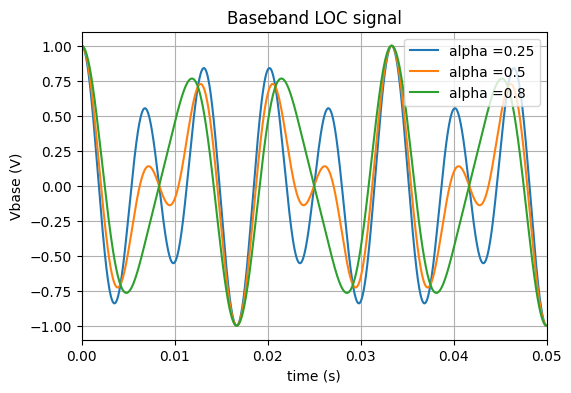

In [2]:
# baseband loc signal generation
#--------------------------------

#paramaters

# Carrier frequency
fc = 10e3
sample_rate = fc * 10.0

f150 = 150.0; A150 = 1.0
f90 = 90.0; A90 = 1.0


#aircraft offset
alpha_range = array([0.25, 0.5, 0.8])

#time
t = arange(0,1.0,1/sample_rate)

#sources
V150 = A150 * cos(2*pi*f150*t)
V90 = A90 * cos(2*pi*f90*t)

figure(figsize=(6,4))
for i, alpha in enumerate(alpha_range): 
    #resistive mixer
    Vbase = (1.0-alpha)*V150 + alpha*V90
    
    plot(t,Vbase,label="alpha =" + str(alpha))
    
xlabel('time (s)')
ylabel('Vbase (V)')
legend()
xlim(0,0.05)
grid()
title("Baseband LOC signal")

show()


Nous allons maintenant étudier le cas où l'avion est dans l'axe de la piste. Dans ce cas $\alpha=0.5$, le programme et la figure ci-dessous présentent le comportement temporel de $V_{base}$ 

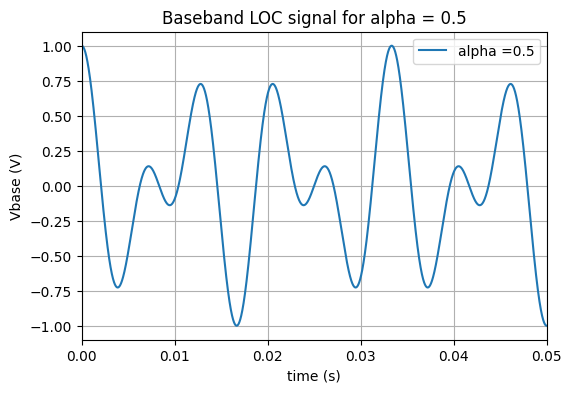

In [3]:
#aircraft offcet
alpha = 0.5

#resistive mixer
Vbase = (1.0-alpha)*V150 + alpha*V90

figure(figsize=(6,4)) 
plot(t,Vbase,label="alpha =" + str(alpha))  
xlabel('time (s)')
ylabel('Vbase (V)')
legend()
xlim(0,0.05)
grid()
title("Baseband LOC signal for alpha = "+str(alpha))

show()

Le spectre unilatéral d'amplitude du signal en bande de base est présenté sur la figure ci-dessous. Il est constitué de deux raies. La première raie correspond au signal "90Hz" et la seconde au signal "150Hz". Ces deux raies ont une amplitude identique, car l'avion est dans l'axe de la piste (i.e. $\alpha=0.5$). L'analyse du signal en réception consistera donc à comparer l'amplitude de ces deux raies pour en déduire la position de l'avion.

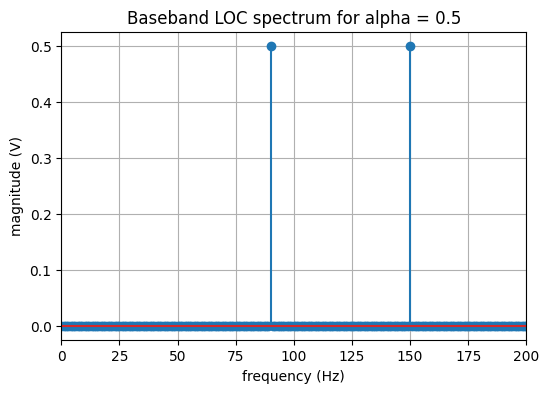

In [4]:
#spectral analysis

Sbase = rfft(Vbase)
Sbase /= len(Sbase)
freq = rfftfreq(len(Vbase),d=1/sample_rate)

figure(figsize=(6,4))
stem(freq,abs(Sbase))
grid()
xlim(0,200)
xlabel('frequency (Hz)')
ylabel('magnitude (V)')
title('Baseband LOC spectrum for alpha = '+str(alpha))
      
show()


## Modulation d'amplitude 

Le signal en bande de base est ensuite modulé en amplitude autour de la fréquence de la porteuse $f_c$. Le taux de modulation est de 40% :

$$
V_{RF} = A_{RF}(1 + 0.4 V_{base})\cos(2 \pi f_c t)
$$

ou $A_{RF}$ est l'amplitude de la porteuse, dans notre cas 1V.

Pour des raisons de simulation, dans ce travail le signal est échantillonné à 100KHz avec $f_c$= 10KHz.   

:::{warning}
Notons que la fréquence de la porteuse ne correspond pas à la valeur utilisée dans le domaine aéronautique (i.e. entre 108.1 et 111.95 MHz). Il s'agit d'une simplification permettant d'économiser nos ressources de calcul.
:::


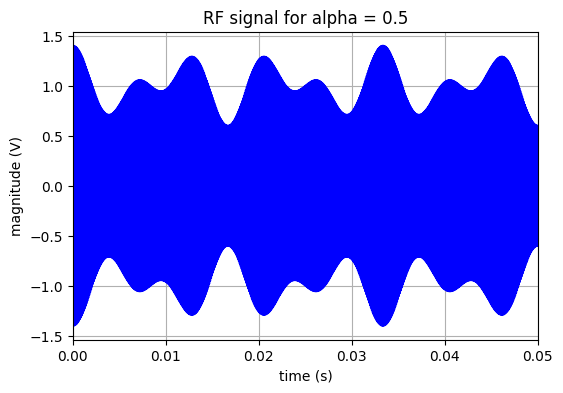

In [5]:
# RF signal

#parameters

#modulation depth
m = 0.4

Arf = 1.0

#set the RF signal (Amplitude Modulation)
Vrf = Arf*(1.0 + m*Vbase)*cos(2*pi*fc*t)

figure(figsize=(6,4))
plot(t,Vrf,'b')
grid()
xlabel('time (s)')
ylabel('magnitude (V)')
title('RF signal for alpha = '+str(alpha))
xlim(0,0.05)

show()

Le spectre d'amplitude unilatéral est présenté sur la figure suivante.

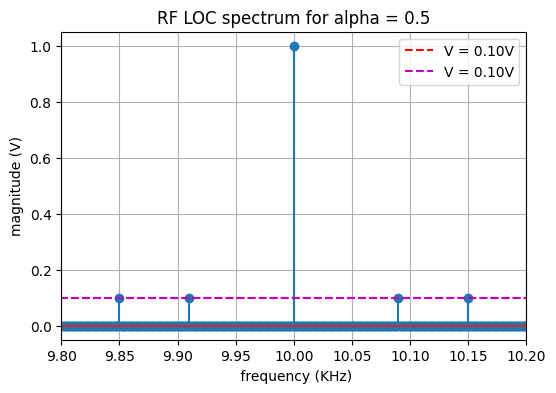

In [6]:
#spectral analysis

Srf = rfft(Vrf)
Srf /= len(Srf) 
Vfreq = rfftfreq(len(Vrf),d=1/sample_rate)
mar150 = (1-alpha)*m/2
mar90 = alpha*m/2

figure(figsize=(6,4))
stem(freq/1e3,abs(Srf))
plot(freq/1e3,mar90*ones_like(abs(Srf)),'--r',label="V = {0:3.2f}V".format(mar90))
plot(freq/1e3,mar150*ones_like(abs(Srf)),'--m',label="V = {0:3.2f}V".format(mar150))
legend()
grid()
xlim(10-0.2,10+0.2)
xlabel(' frequency (KHz)')
ylabel('magnitude (V)')
title('RF LOC spectrum for alpha = '+str(alpha))
      
show()

Le spectre du signal RF présente une raie principale à la fréquence de la porteuse (dans notre cas $f_c$=10 KHz) et de part et d'autre de cette fréquence, le spectre du signal en bande de base constitué de deux raies dont l'amplitude est liée à la position de l'avion (i.e. $\alpha$) mais aussi au taux de modulation.

Pour cet exemple, comme l'avion est centré ($\alpha=0.5$), l'amplitude des raies "90Hz" et "150Hz" est identique.

Il convient de s’arrêter sur la nécessité de moduler puisque l'information de la position de l'avion est déjà "portée" par le signal en bande de base. 

:::{tip} Pourquoi moduler ! 💬
:class: dropdown

La modulation RF permet de transposer le signal en bande de base autour de la fréquence de la porteuse. Il s'agit donc de "déplacer", le signal informatif vers une fréquence plus élevée. On peut s'interroger sur la nécessité de réaliser cette transposition fréquentielle ?

IL existe plusieurs réponses à cette question :

* La dimension des antennes est liée à la fréquence transmise (plus exactement à la longueur d'onde $\lambda$ qui est définie par $\lambda = c/f$ avec $c=3e8$m/s et $f$ la fréquence du signal en Hz). Dans notre cas la fréquence du signal en bande de base est voisin de 120Hz, ce qui entraîne une longueur d'onde de 2500Km !, il faudrait donc avoir des antennes dont les dimensions sont proches de cette valeur !. Le fait de transposer le signal de 90Hz où 150Hz autour de 110MHz entraine des dimensions d'antenne dans le domaine métrique. Ainsi le fait d'augmenter la fréquence permet de réduire la taille des antennes mais aussi leurs encombrements et leurs poids. Toutefois le fait d'augmenter la fréquence présente aussi des inconvénients notamment sur les conditions de propagation: les pertes de propagations sont inversement proportionnelles au carré de la fréquence. De plus les ondes ont plus de difficultés à se propager à travers des interfaces telle que des murs lorsque la fréquence augmente.
* Le bruit de fond notamment celui provenant des activités humaines est plus important en basse fréquence. De ce fait pour pouvoir détecter le signal, il faudra l'émettre avec plus de puissance en basse fréquence.

Voici donc les deux principaux arguments pour utiliser une fréquence RF pour transmettre une information.
:::

## Signal reçu par l'avion

Dans une première approximation, on considère que le signal reçu par l'avion $Vr_{RF}$ correspond au signal transmis $V_{RF}$ retardé et atténué :

$$
Vr_{RF}(t) = \beta V_{RF}(t-t_d)
$$

avec $\beta$ l'atténuation du signal ($0<\beta < 1$) et $t_d$ le temps de propagation du signal.

La figure ci_dessous présente le signal reçu lorsque l'avion est à une distance de $R=$3000m de l'émetteur du "localiser". Pour des raisons de simplification, on suppose que le signal n'est pas atténué ($\beta=1$). Le temps de propagation $t_d$ s'exprime simplement à partir de :

$$
t_d = \frac{R}{c}
$$

avec $c=$ 3e8m/s.

temps de propagation : 10.00us


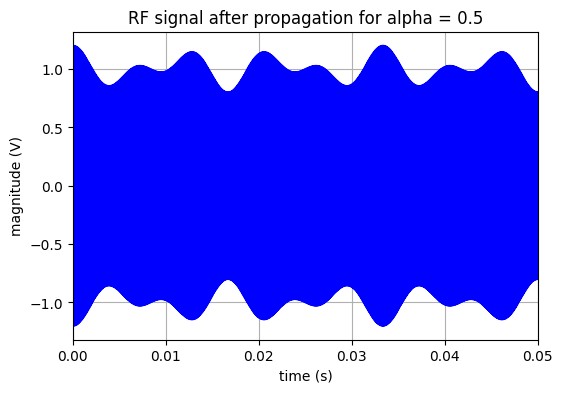

In [7]:
# LOC signal received by aircraft

def Vrf(t,alpha):
    """
    LOC signal calculation
    """
    A90 =1.0
    A150 = 1.0
    f90 = 90.0
    f150 = 150.0
    Arf =1.0
    m = 0.2
    fc = 10e3
    
    V150 = A150 * cos(2*pi*f150*t)
    V90 = A90 * cos(2*pi*f90*t)
    Vbase = (1.0-alpha)*V150 + alpha*V90
    Vrf = Arf*(1.0 + m*Vbase)*cos(2*pi*fc*t)
    return Vrf
    
distance = 3000.0
tp = distance / 3e8
beta = 1

print(f"temps de propagation : {tp/1e-6:3.2f}us")

Vr_rf = beta*Vrf(t-tp,alpha)

figure(figsize=(6,4))
plot(t,Vr_rf,'b')
grid()
xlabel('time (s)')
ylabel('magnitude (V)')
title('RF signal after propagation for alpha = '+str(alpha))
xlim(0,0.05)
show()

### Ajout d'un bruit gaussien avec un SNR fixé

L'avion reçoit le signal atténué et retardé additionné d'un bruit ($b(t)$) qui provient de l'environnement :

$$
Vr_{RF}(t) = \beta V_{RF}(t-t_d) + b(t)
$$

Classiquement la puissance du bruit s'exprime en fonction de la puissance du signal en utilisant la définition du [rapport signal sur bruit](https://fr.wikipedia.org/wiki/Rapport_signal_sur_bruit) (SNR: Signal Noise Ratio) :

$$
SNR_{dB}=10\log(\frac{P_{signal}}{P_{bruit}})
$$

Dans cette équation, le SNR est exprimé en dB. $P_{signal}$ est la puissance du signal exprimée en W et $P_{bruit}$, la puissance du bruit en W.

Dans notre exemple, nous considérons un SNR de 20dB.

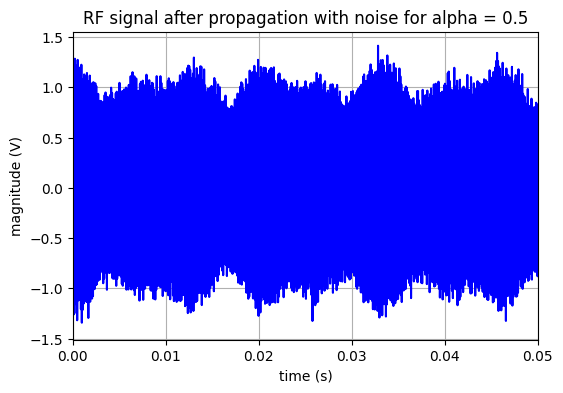

In [10]:
# add noise 

def add_noise(s, SNR):
    """    
    Compute d = s + n such that SNR = Ps/Pn
    s: Input signal
    SNR: Desired signal-to-noise ratio
    d: Output signal
    """
    n = random.randn(len(s))
    Es = sum(s**2)
    En = sum(n**2)
    alpha = sqrt(Es/(SNR*En))
    d = s+alpha*n
    return d

#SNR in dB
SNR = 20
snr = 10**(SNR/10)
Vr_rfb = add_noise(Vr_rf,snr) 

figure(figsize=(6,4))
plot(t,Vr_rfb,'b')
grid()
xlabel('time (s)')
ylabel('magnitude (V)')
title('RF signal after propagation with noise for alpha = '+str(alpha))
xlim(0,0.05)
show()

Finalement nous sauvegardons le signal reçu par l'avion dans un fichier texte pour pouvoir le réutiliser lors de la prochaine leçon.

In [17]:
#save the LOC data

#parameter
file_name = '../_static/data/loc_data.txt'

with open(file_name, 'w') as f:
    for i in range(len(t)):
        line = str(t[i])+','+str(Vr_rfb[i])+'\n'
        f.write(line)

:::{admonition} Synthèse
:class: tip

Dans cette page nous avons vu comment simuler le signal reçu par l'avion en fonction de sa position par rapport à l'axe de la piste. Pour cela nous avons "fabriqué" le signal en bande de base, puis nous l'avons transposé autour de la fréquence de la porteuse en utilisant une modulation d'amplitude. Le canal de propagation a été ensuite simulé et enfin un bruit gaussien à été ajouté.

Dans la suite nous allons chercher à traiter le signal reçu par l'avion pour en déduire une information de position.

:::